## Generate Mask for human object activation ratio ##

Please run this code to generate the mask pkl file for human object activation ratio.

SAM2 requires different torch version and python version from mmpretrain. Therefore, please ron  this notebook in a separate conda environment.


In [1]:
!git clone https://github.com/facebookresearch/sam2.git sam2_repo

The value specified in an AutoRun registry key could not be parsed.
Cloning into 'sam2_repo'...


In [2]:
!pip install -e sam2_repo

Obtaining file:///C:/Users/crane/Desktop/ViTs_Social_Bias_Analysis/sam2_repo
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for SAM-2 (pyproject.toml): started
  Building editable for SAM-2 (pyproject.toml): finished with status 'done'
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-py3-none-any.whl size=13920 sha256=cddc6effb677173252422cb7d02571c331552c42220a61a020d023f1f3bab057
  Stored in directory: C:\Users\crane\AppData\Local\Temp\pip-ephem-wheel-cache-re_d_xgx\wheels\d0\ab\96\c0333a381deade029fb75c219535723e79

The value specified in an AutoRun registry key could not be parsed.


To download the necessary checkpoint files for SAM2, run the following command in your terminal:

For Linux/macOS (or WSL/Git Bash on Windows):
```bash
cd sam2_repo/checkpoints
./download_ckpts.sh
```


In [ ]:
import os
from PIL import Image
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import SamModel, SamProcessor
import pickle

# resize image to 224,384
# vit grey image - 384x384
# other models grey image - 224x224

def resize_all(size):
	if not os.path.exists(f"data/data_{size}"):
		os.makedirs(f"data/data_{size}")

	for b in ['black-female','black-male','female','male','white-female','white-male']:
		if not os.path.exists(f"data/data_{size}/"+b):
			os.makedirs(f"data/data_{size}/"+b)
		save_dir = os.path.join(f"data/data_{size}/", b+"/")
		if b == "male" or b == "female":
			for path in os.listdir("data/experiments/gender/"+b):
				img = Image.open("data/experiments/gender/"+b+"/"+path)
				img.thumbnail((size, size))
				img = img.resize((size, size))
				img.save(save_dir+path)
		else:
			for path in os.listdir("data/experiments/intersectional/"+b):
				img = Image.open("data/experiments/intersectional/"+b+"/"+path)
				img = img.resize((size, size))
				img.save(save_dir+path)
def show_mask(mask, ax, random_color=False):
		if random_color:
				color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
		else:
				color = np.array([30/255, 144/255, 255/255, 0.6])
		h, w = mask.shape[-2:]
		mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
		ax.imshow(mask_image)


def show_box(box, ax):
		x0, y0 = box[0], box[1]
		w, h = box[2] - box[0], box[3] - box[1]
		ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
		plt.figure(figsize=(10,10))
		plt.imshow(raw_image)
		for box in boxes:
			show_box(box, plt.gca())
		plt.axis('on')
		plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
		plt.figure(figsize=(3,3))
		plt.imshow(raw_image)
		input_points = np.array(input_points)
		if input_labels is None:
			labels = np.ones_like(input_points[:, 0])
		else:
			labels = np.array(input_labels)
		show_points(input_points, labels, plt.gca())
		plt.axis('on')
		plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
		plt.figure(figsize=(10,10))
		plt.imshow(raw_image)
		input_points = np.array(input_points)
		if input_labels is None:
			labels = np.ones_like(input_points[:, 0])
		else:
			labels = np.array(input_labels)
		show_points(input_points, labels, plt.gca())
		for box in boxes:
			show_box(box, plt.gca())
		plt.axis('on')
		plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
		plt.figure(figsize=(10,10))
		plt.imshow(raw_image)
		input_points = np.array(input_points)
		if input_labels is None:
			labels = np.ones_like(input_points[:, 0])
		else:
			labels = np.array(input_labels)
		show_points(input_points, labels, plt.gca())
		for box in boxes:
			show_box(box, plt.gca())
		plt.axis('on')
		plt.show()


def show_points(coords, labels, ax, marker_size=375):
		pos_points = coords[labels==1]
		neg_points = coords[labels==0]
		ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
		ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
		if len(masks.shape) == 4:
			masks = masks.squeeze()
		if scores.shape[0] == 1:
			scores = scores.squeeze()

		nb_predictions = scores.shape[-1]
		fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

		for i, (mask, score) in enumerate(zip(masks, scores)):
			mask = mask.cpu().detach()
			axes[i].imshow(np.array(raw_image))
			show_mask(mask, axes[i])
			axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
			axes[i].axis("off")
		plt.show()
	  
def mask_generation(size, input_points_dict):
	all_mask = {}
	device = "cuda" if torch.cuda.is_available() else "cpu"
	model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
	for b in ["black-male", "black-female", "white-male", "white-female", "male", "female"]:
		mask = {}
		for path in os.listdir(f"data/data_{size}/"+b):
			img_url = f"data/data_{size}/"+b+"/"+path
			raw_image = Image.open(img_url).convert("RGB")
			inputs = processor(raw_image, return_tensors="pt").to(device)
			image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
			input_points = input_points_dict[b][path]
			inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
			# pop the pixel_values as they are not neded
			inputs.pop("pixel_values", None)
			inputs.update({"image_embeddings": image_embeddings})

			with torch.no_grad():
				outputs = model(**inputs)

			masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
			scores = outputs.iou_scores
			torch.cuda.empty_cache()
			mask[path] = masks
			print(path)
			show_points_on_image(raw_image, input_points[0], input_labels=[1])
			show_masks_on_image(raw_image, masks[0], scores)
			torch.cuda.empty_cache()
		torch.cuda.empty_cache()
		all_mask[b] = mask
	with open(f'mask_{size}.pkl', 'wb') as f:
		pickle.dump(all_mask, f)

Generate resized images tailored to each model grey scale image size

In [ ]:
resize_all(224)
resize_all(384)

Define input points for the SAM2 model (this is an example of 384)

In [20]:
#define input points for each image manually
input_points_dict = {
    "black-male": {
	"bm1.jpg" : [[[160,90]]],
	"bm10.jpg" : [[[160,90]]],
	"bm11.png" : [[[160,90]]],
	"bm12.webp" : [[[190,150]]], #rerun 190,150
	"bm13.jpeg" : [[[210,150]]], #rerun 220,180
	"bm14.jpeg" : [[[220,180]]], #rerun 220,180
	"bm15.jpg" : [[[160,90]]],
	"bm16.jpg" : [[[200,100]]],
	"bm17.jpg" : [[[220,180]]], #rerun 220,180
	"bm18.jpg" : [[[220,180]]], #rerun 220,180
	"bm19.jpg" : [[[160,90]]],
	"bm2.jpeg" : [[[190,150]]], #rerun 100,100
	"bm20.jpg" : [[[160,90]]],
	"bm3.jpg" : [[[220,180]]], #rerun 220,180
	"bm4.jpg" : [[[160,90]]],
	"bm5.jpg" : [[[100,100]]], #rerun 100,100
	"bm6.jpeg" : [[[160,90]]],
	"bm7.jpg" : [[[120,200]]], #rerun 120,200
	"bm8.jpg" : [[[250,200]]], #rerun 250,200
	"bm9.jpg" : [[[250,200]]], #rerun 250,200
},
    "black-female": {
	"bf1.jpg" : [[[160,90]]],
	"bf10.jpg" : [[[180,180]]], #rerun 180,180
	"bf11.jpeg" : [[[160,90]]],
	"bf12.jpg" : [[[50,40]]], #rerun 50,40
	"bf13.jpg" : [[[160,90]]],
	"bf14.jpeg" : [[[180,180]]], #rerun 180,180
	"bf15.jpg" : [[[160,90]]], 
	"bf16.jpg" : [[[180,180]]], #rerun 180,180
	"bf17.jpg" : [[[180,180]]], #rerun 180,180
	"bf18.jpeg" : [[[180,160]]], #rerun 180,160
	"bf19.jpg" : [[[300,160]]], #rerun 300,160
	"bf2.jpeg" : [[[112,100]]], #rerun 112,100
	"bf20.jpg" : [[[160,90]]], 
	"bf3.jpg" : [[[160,90]]],
	"bf4.jpg" : [[[160,90]]],
	"bf5.jpg" : [[[160,90]]], 
	"bf6.jpg" : [[[160,90]]],
	"bf7.webp" : [[[160,90]]],
	"bf8.jpg" : [[[160,90]]],
	"bf9.jpg" : [[[220,120]]], #rerun 220,120
},
    "white-male": {
    "wm1.jpg" : [[[160,90]]],
	"wm10.jpg" : [[[220,120]]], #rerun 220,120
	"wm11.jpg" : [[[160,90]]],
	"wm12.jpg" : [[[220,50]]], #rerun 220,50
	"wm13.jpg" : [[[180,50]]], #rerun 180,50
	"wm14.jpg" : [[[160,90]]],
	"wm15.jpeg" : [[[180,50]]], #rerun 180,50
	"wm16.jpg" : [[[250,50]]], #rerun 250,50
	"wm17.jpg" : [[[160,90]]],
	"wm18.jpg" : [[[100,40]]], #rerun 100,40
	"wm19.jpg" : [[[160,90]]],
	"wm2.jpeg" : [[[250,120]]], #rerun 250,120
	"wm20.jpg" : [[[160,90]]],
	"wm3.jpg" : [[[160,90]]],
	"wm4.jpg" : [[[160,90]]],
	"wm5.jpg" : [[[50,120]]], #rerun 50,120
	"wm6.jpg" : [[[160,90]]],
	"wm7.jpg" : [[[150,40]]], #rerun 150,40
	"wm8.jpg" : [[[160,90]]],
	"wm9.jpg" : [[[250,120]]], #rerun 250,120
},
    "white-female": {
    "wf1.jpg" : [[[160,90]]],
	"wf10.jpg" : [[[100,40]]], #rerun 100,40
	"wf11.jpg" : [[[180,80]]], #rerun 180,80
	"wf12.jpg" : [[[180,80]]], #rerun 180,80
	"wf13.jpg" : [[[120,40]]], #rerun 120,40
	"wf14.jpg" : [[[240,80]]], #rerun 240,80
	"wf15.jpg" : [[[160,90]]],
	"wf16.jpg" : [[[240,80]]], #rerun 240,80
	"wf17.jpg" : [[[210,120]]], #rerun 210,120
	"wf18.jpg" : [[[210,120]]], #rerun 210,120
	"wf19.jpg" : [[[210,120]]], #rerun 210,120
	"wf2.jpg" : [[[160,90]]],
	"wf20.jpg" : [[[150,40]]], #rerun 150,40
	"wf3.jpeg" : [[[160,90]]],
	"wf4.jpeg" : [[[210,120]]], #rerun 210,120
	"wf5.jpg" : [[[80,20]]], #rerun 80,20
	"wf6.jpg" : [[[160,90]]],
	"wf7.jpg" : [[[100,20]]], #rerun 100,20
	"wf8.jpg" : [[[160,90]]],
	"wf9.jpeg" : [[[160,90]]],
},
    "male":  {
    "boy10_google.jpg": [[[160,90]]],
    "boy1_google.jpg":[[[210,120]]], #rerun 210,120
    "boy2_google.jpg":[[[210,120]]], #rerun 210,120
    "boy3_google.jpg":[[[100,20]]], #rerun 100,20
    "boy4_google.jpg":[[[160,90]]],
    "boy5_google.jpg":[[[100,20]]], #rerun 100,20
    "boy6_google.jpg":[[[100,20]]], #rerun 100,20
    "boy7_google.jpg":[[[80,70]]], #rerun 80,70
    "boy8_google.jpg":[[[210,120]]], #rerun 210,120
    "boy9_google.jpg":[[[160,90]]],
    "grandpa10_google.jpg":[[[160,90]]],
    "grandpa1_google.webp":[[[180,30]]], #rerun 180,30
    "grandpa2_google.jpg":[[[160,90]]],
	"grandpa3_google.jpg":[[[110,50]]], #rerun 110,50
	"grandpa4_google.jpg":[[[160,90]]], 
	"grandpa5_google.jpg":[[[160,90]]],
 	"grandpa6_google.jpg":[[[160,90]]],
  	"grandpa7_google.jpg":[[[160,90]]],
	"grandpa8_google.jpg":[[[160,90]]],
	"grandpa9_google.jpg":[[[220,100]]], #rerun 220,100
	"male10_google.jpg":[[[160,90]]],
	"male1_google.jpg":[[[60,100]]], #rerun 60,100
	"male2_google.jpg":[[[180,40]]], #rerun 180,40
	"male3_google.jpg":[[[160,90]]],
	"male4_google.png":[[[180,40]]], #rerun 180,40
	"male5_google.jpg":[[[160,90]]],
	"male6_google.jpg":[[[180,40]]], #rerun 180,40
	"male7_google.jpg":[[[180,40]]], #rerun 180,40
	"male8_google.jpg":[[[160,90]]],
	"male9_google.jpg":[[[95,40]]], #rerun 95,40
	"man10_google.jpg":[[[100,15]]], #rerun 100,15
	"man1_google.jpg":[[[240,140]]], #rerun 240,140
	"man2_google.jpg":[[[110,20]]], #rerun 110,20
	"man3_google.jpg":[[[100,15]]], #rerun 100,15
	"man4_google.jpg":[[[100,25]]], #rerun 100,25
	"man5_google.jpg":[[[75,40]]], #rerun 75,40
	"man6_google.jpg":[[[180,70]]], #rerun 180,70
	"man7_google.jpg":[[[160,90]]], 
	"man8_google.jpg":[[[180,70]]], #rerun 180,70
	"man9_google.jpg":[[[160,90]]], 
},
    "female": {
	"female10_google.jpeg":[[[250,100]]], #rerun 250,100
	"female1_google.jpg":[[[160,90]]],
 	"female2_google.jpg":[[[250,100]]], #rerun 250,100
  	"female3_google.jpg":[[[180,80]]], #rerun 180,80
   	"female4_google.jpg":[[[100,40]]], #rerun 100,40
    "female5_google.jpg":[[[160,90]]],
    "female6_google.jpg":[[[80,40]]], #rerun 80,40
    "female7_google.jpg":[[[160,90]]],
    "female8_google.jpg":[[[80,20]]], #rerun 80,20
    "female9_google.jpg":[[[100,40]]], #rerun 100,40
    "girl10_google.jpg":[[[160,90]]],
    "girl1_google.jpg":[[[160,90]]],
    "girl2_google.jpeg":[[[230,80]]], #rerun 230,80
    "girl3_google.jpg":[[[200,40]]], #rerun 200,40
    "girl4_google.jpeg":[[[220,140]]], #rerun 220,140
    "girl5_google.jpg":[[[160,90]]], 
    "girl6_google.jpg":[[[220,140]]], #rerun 220,140
    "girl7_google.jpg":[[[90,50]]], #rerun 90,50
    "girl8_google.jpg":[[[220,140]]], #rerun 220,140
    "girl9_google.jpg":[[[160,90]]], 
    "grandma10_google.jpg":[[[220,140]]], #rerun 220,140
    "grandma1_google.jpg":[[[220,140]]], #rerun 220,140
    "grandma2_google.jpg":[[[220,140]]], #rerun 220,140
    "grandma3_google.jpg":[[[220,140]]], #rerun 220,140
    "grandma4_google.jpeg":[[[220,140]]], #rerun 220,140
    "grandma5_google.jpg":[[[220,140]]], #rerun 220,140
    "grandma6_google.jpg":[[[160,90]]],
    "grandma7_google.jpg":[[[90,50]]], #rerun 90,50
    "grandma8_google.jpg":[[[130,100]]], #rerun 130,100
    "grandma9_google.png":[[[90,50]]], #rerun 90,50
    "woman10_google.jpg":[[[160,90]]],
    "woman1_google.jpg":[[[160,90]]],
    "woman2_google.jpg":[[[90,50]]], #rerun 90,50
    "woman3_google.jpg":[[[160,90]]],
	"woman4_google.jpg":[[[160,90]]],
	"woman5_google.jpg":[[[90,90]]], #rerun 90,90
	"woman6_google.jpg":[[[220,140]]], #rerun 220,140
	"woman7_google.jpeg":[[[220,140]]], #rerun 220,140
	"woman8_google.jpg":[[[220,140]]], #rerun 220,140
 	"woman9_google.jpeg":[[[160,90]]], 
}
}

bm1.jpg


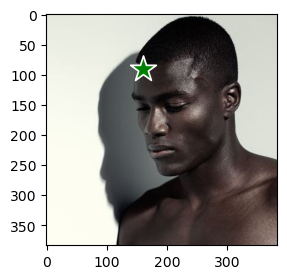

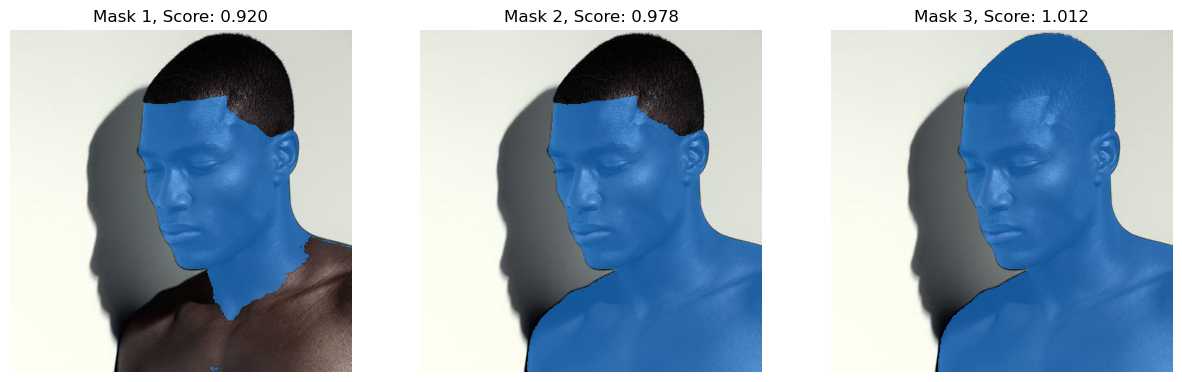

bm10.jpg


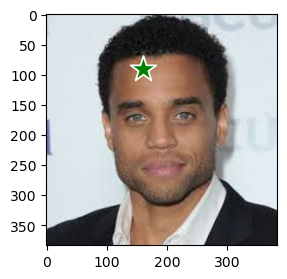

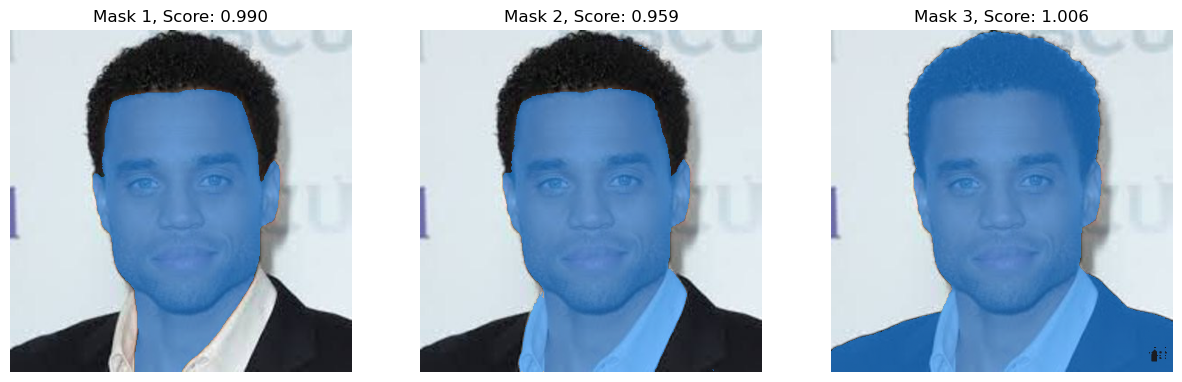

bm11.png


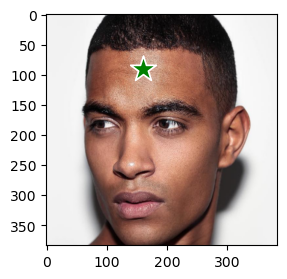

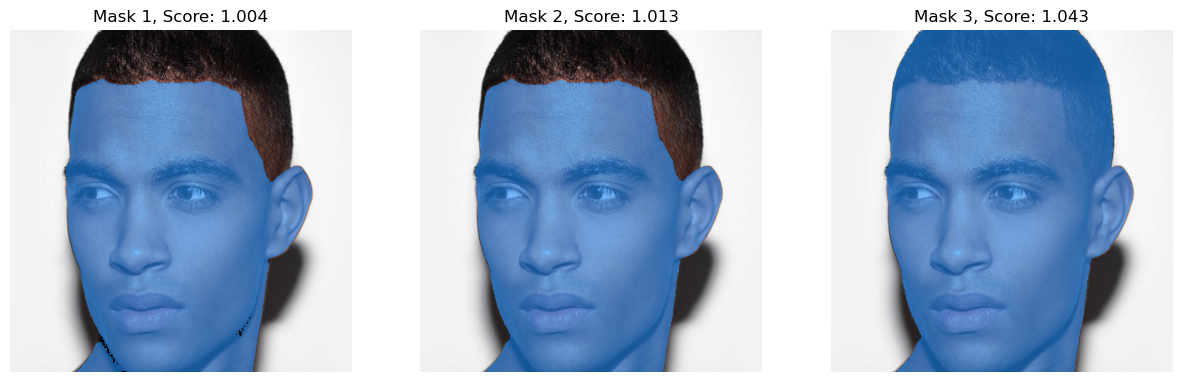

bm12.webp


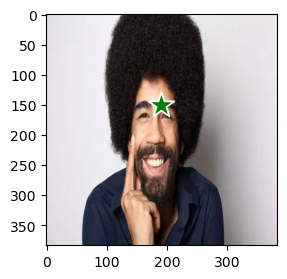

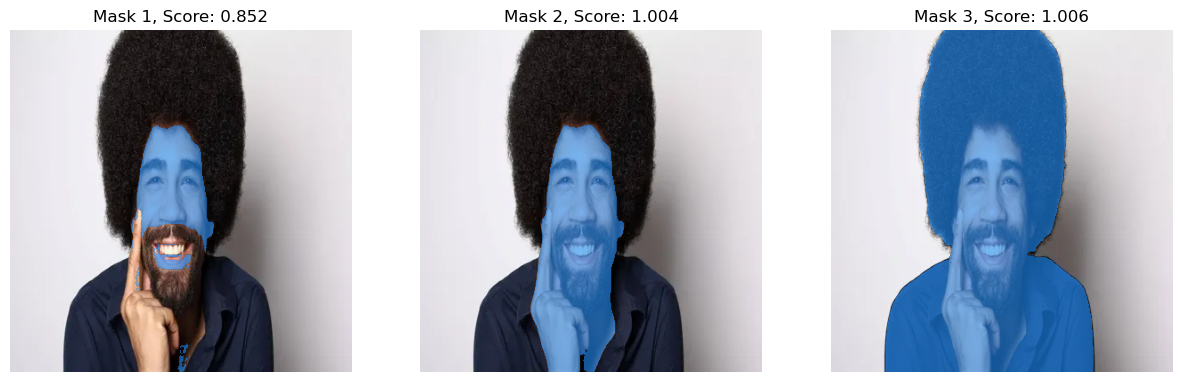

bm13.jpeg


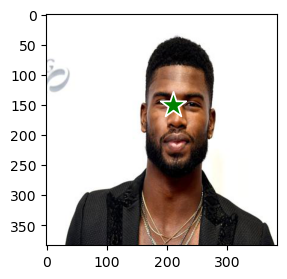

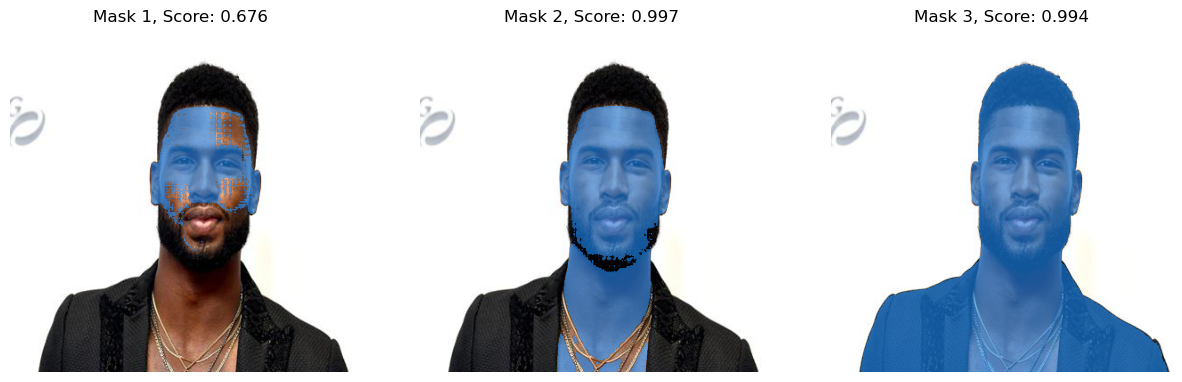

bm14.jpeg


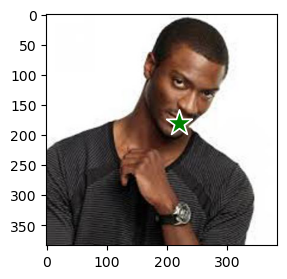

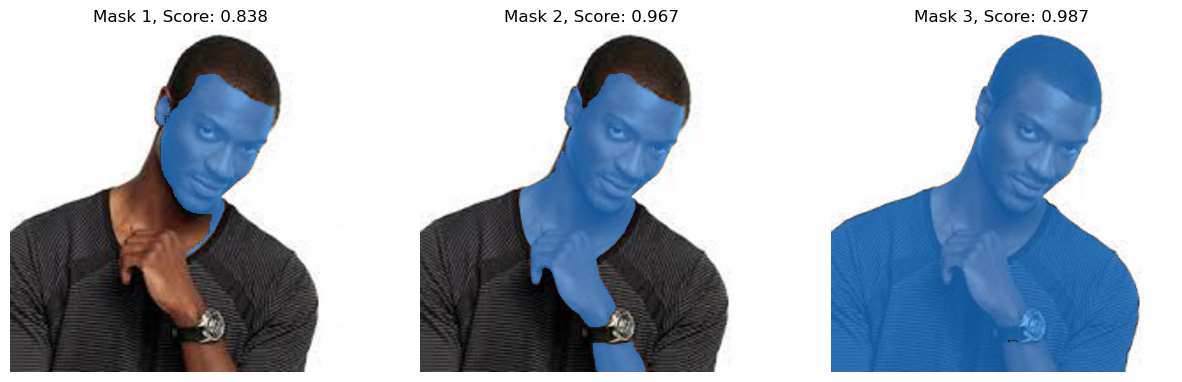

bm15.jpg


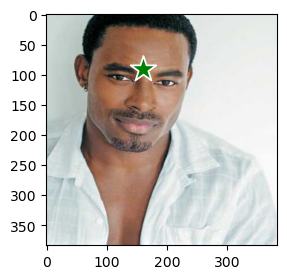

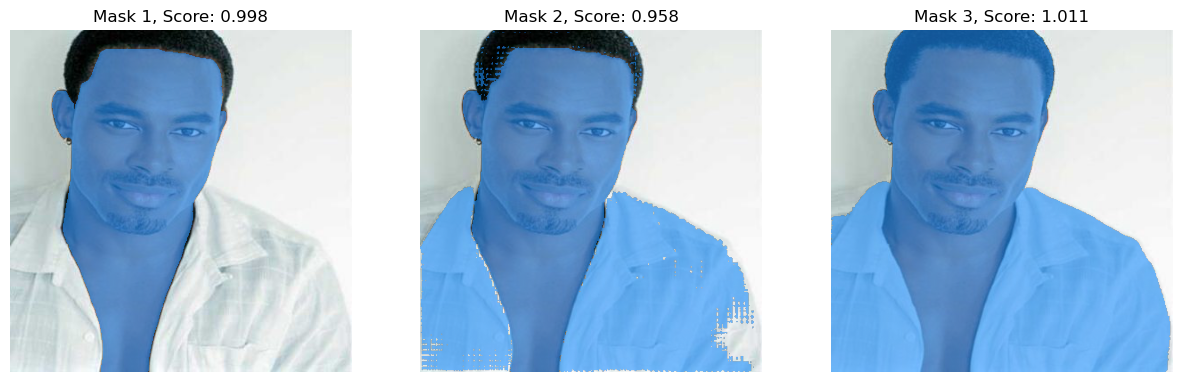

bm16.jpg


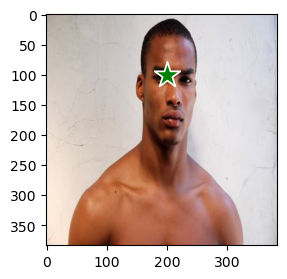

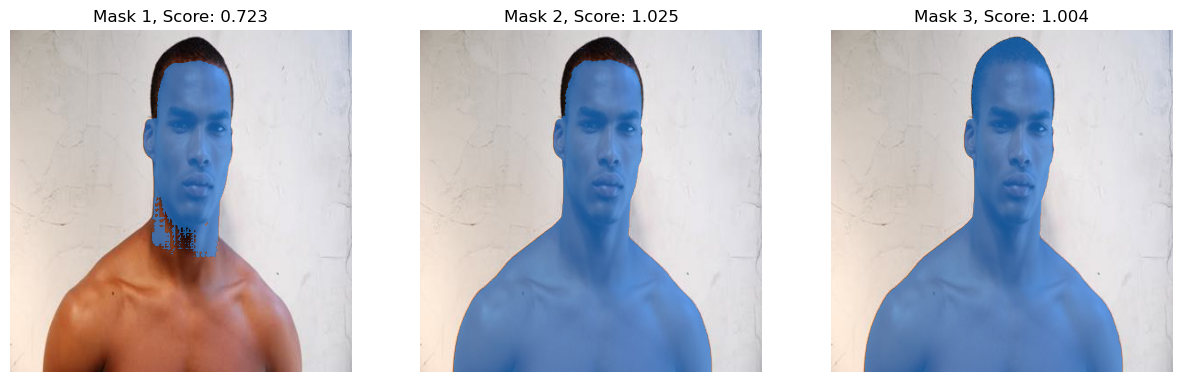

bm17.jpg


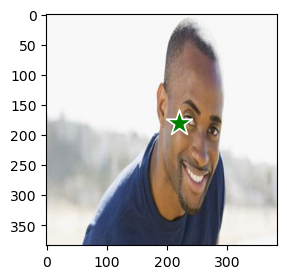

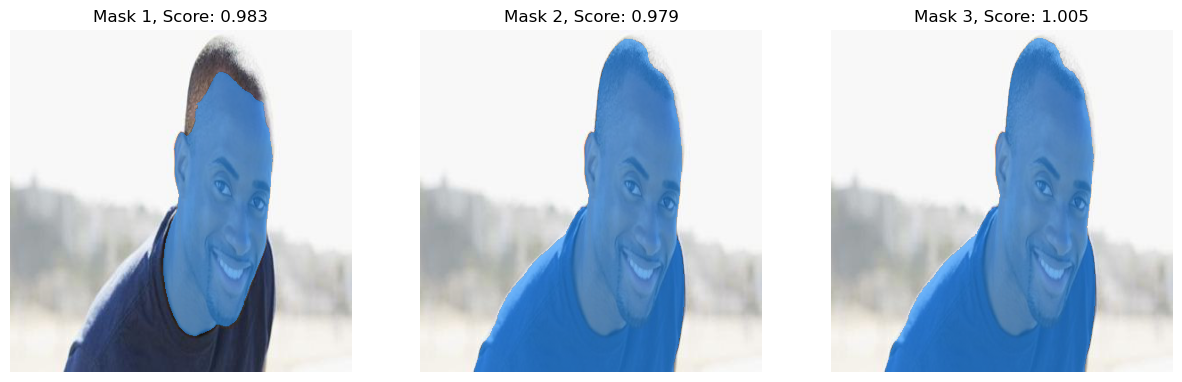

In [ ]:
mask_generation(384, input_points_dict)

Based on the segmentations in a row, choose index for face and one for entire human shilhouette

Then copy this code to mask_index_{size}.py file

In [ ]:
mask_index_bm = {
	"bm1.jpg" : [0,2],
	"bm10.jpg" : [0,2],
	"bm11.png" : [0,2],
	"bm12.webp" : [1,2], #rerun 190,150
	"bm13.jpeg" : [0,2], #rerun 220,180
	"bm14.jpeg" : [0,2], #rerun 220,180
	"bm15.jpg" : [0,2],
	"bm16.jpg" : [0,2],
	"bm17.jpg" : [0,2], #rerun 220,180
	"bm18.jpg" : [0,2], #rerun 220,180
	"bm19.jpg" : [0,2],
	"bm2.jpeg" : [0,2], #rerun 100,100
	"bm20.jpg" : [0,2],
	"bm3.jpg" : [0,2], #rerun 220,180
	"bm4.jpg" : [0,2],
	"bm5.jpg" : [0,2], #rerun 100,100
	"bm6.jpeg" : [0,2],
	"bm7.jpg" : [0,2], #rerun 120,200
	"bm8.jpg" : [1,2], #rerun 250,200
	"bm9.jpg" : [1,2], #rerun 250,200
}
mask_index_bf = {
	"bf1.jpg" : [0,2],
	"bf10.jpg" : [0,2], #rerun 180,180
	"bf11.jpeg" : [0,2],
	"bf12.jpg" : [0,2], #rerun 50,40
	"bf13.jpg" : [0,2],
	"bf14.jpeg" : [0,2], #rerun 180,180
	"bf15.jpg" : [0,2], 
	"bf16.jpg" : [0,2], #rerun 180,180
	"bf17.jpg" : [0,2], #rerun 180,180
	"bf18.jpeg" : [0,2], #rerun 180,160
	"bf19.jpg" : [0,2], #rerun 300,160
	"bf2.jpeg" : [0,2], #rerun 112,100
	"bf20.jpg" : [0,2], 
	"bf3.jpg" : [0,2],
	"bf4.jpg" : [0,2],
	"bf5.jpg" : [0,2], 
	"bf6.jpg" : [1,2],
	"bf7.webp" : [0,2],
	"bf8.jpg" : [0,2],
	"bf9.jpg" : [0,2], #rerun 220,120
}

mask_index_wm = {
    "wm1.jpg" : [0,2],
	"wm10.jpg" : [1,2], #rerun 220,120
	"wm11.jpg" : [0,2],
	"wm12.jpg" : [0,2], #rerun 220,50
	"wm13.jpg" : [0,2], #rerun 180,50
	"wm14.jpg" : [0,2],
	"wm15.jpeg" : [0,2], #rerun 180,50
	"wm16.jpg" : [0,2], #rerun 250,50
	"wm17.jpg" : [0,2],
	"wm18.jpg" : [0,2], #rerun 100,40
	"wm19.jpg" : [0,2],
	"wm2.jpeg" : [0,2], #rerun 250,120
	"wm20.jpg" : [0,2],
	"wm3.jpg" : [0,2],
	"wm4.jpg" : [0,2],
	"wm5.jpg" : [0,2], #rerun 50,120
	"wm6.jpg" : [0,2],
	"wm7.jpg" : [0,2], #rerun 150,40
	"wm8.jpg" : [0,2],
	"wm9.jpg" : [0,2], #rerun 250,120
}

mask_index_wf = {
    "wf1.jpg" : [0,2],
	"wf10.jpg" : [0,2], #rerun 100,40
	"wf11.jpg" : [0,2], #rerun 180,80
	"wf12.jpg" : [0,2], #rerun 180,80
	"wf13.jpg" : [1,2], #rerun 120,40
	"wf14.jpg" : [0,2], #rerun 240,80
	"wf15.jpg" : [0,2],
	"wf16.jpg" : [0,2], #rerun 240,80
	"wf17.jpg" : [0,2], #rerun 210,120
	"wf18.jpg" : [0,2], #rerun 210,120
	"wf19.jpg" : [0,2], #rerun 210,120
	"wf2.jpg" : [0,2], 
	"wf20.jpg" : [0,2], #rerun 150,40
	"wf3.jpeg" : [1,2],
	"wf4.jpeg" : [0,2], #rerun 210,120
	"wf5.jpg" : [0,2], #rerun 80,20
	"wf6.jpg" : [0,2],
	"wf7.jpg" : [0,2], #rerun 100,20
	"wf8.jpg" : [0,2],
	"wf9.jpeg" : [0,2],
}

mask_index_male = {
    "boy10_google.jpg": [0,2],
    "boy1_google.jpg":[0,2], #rerun 210,120
    "boy2_google.jpg":[0,2], #rerun 210,120
    "boy3_google.jpg":[0,2], #rerun 100,20
    "boy4_google.jpg":[0,2],
    "boy5_google.jpg":[0,2], #rerun 100,20
    "boy6_google.jpg":[0,2], #rerun 100,20
    "boy7_google.jpg":[1,2], #rerun 80,70
    "boy8_google.jpg":[0,2], #rerun 210,120
    "boy9_google.jpg":[0,2],
    "grandpa10_google.jpg":[1,2],
    "grandpa1_google.webp":[0,2], #rerun 180,30
    "grandpa2_google.jpeg":[1,2],
	"grandpa3_google.jpg":[1,2], #rerun 110,50
	"grandpa4_google.webp":[1,2], 
	"grandpa5_google.jpeg":[0,2],
 	"grandpa6_google.webp":[0,2],
  	"grandpa7_google.jpg":[1,2],
	"grandpa8_google.jpg":[0,2],
	"grandpa9_google.jpg":[0,2], #rerun 220,100
	"male10_google.jpg":[0,2],
	"male1_google.jpg":[0,2], #rerun 60,100
	"male2_google.jpg":[1,2], #rerun 180,40
	"male3_google.jpg":[1,2],
	"male4_google.png":[0,2], #rerun 180,40
	"male5_google.jpg":[0,2],
	"male6_google.jpg":[0,2], #rerun 180,40
	"male7_google.jpg":[0,2], #rerun 180,40
	"male8_google.jpg":[0,2],
	"male9_google.jpg":[0,2], #rerun 95,40
	"man10_google.jpg":[0,2], #rerun 100,15
	"man1_google.jpg":[0,2], #rerun 240,140
	"man2_google.jpg":[0,2], #rerun 110,20
	"man3_google.jpg":[0,2], #rerun 100,15
	"man4_google.jpg":[0,2], #rerun 100,25
	"man5_google.jpg":[0,2], #rerun 75,40
	"man6_google.jpg":[0,2], #rerun 180,70
	"man7_google.jpg":[0,2], 
	"man8_google.jpg":[0,2], #rerun 180,70
	"man9_google.jpg":[0,2], 
}

mask_index_female = {
	"female10_google.jpeg":[0,2], #rerun 250,100
	"female1_google.jpg":[0,2],
 	"female2_google.jpg":[0,2], #rerun 250,100
  	"female3_google.jpg":[0,2], #rerun 180,80
   	"female4_google.jpg":[0,2], #rerun 100,40
    "female5_google.jpeg":[0,2],
    "female6_google.jpg":[0,2], #rerun 80,40
    "female7_google.jpg":[0,2],
    "female8_google.jpg":[0,2], #rerun 80,20
    "female9_google.jpg":[0,2], #rerun 100,40
    "girl10_google.jpg":[0,2],
    "girl1_google.webp":[0,2],
    "girl2_google.jpeg":[0,2], #rerun 230,80
    "girl3_google.jpg":[0,2], #rerun 200,40
    "girl4_google.jpeg":[0,2], #rerun 220,140
    "girl5_google.jpg":[1,2], 
    "girl6_google.jpg":[0,2], #rerun 220,140
    "girl7_google.jpg":[0,2], #rerun 90,50
    "girl8_google.jpg":[0,2], #rerun 220,140
    "girl9_google.jpg":[0,2], 
    "grandma10_google.jpg":[0,2], #rerun 220,140
    "grandma1_google.jpg":[0,2], #rerun 220,140
    "grandma2_google.jpg":[0,2], #rerun 220,140
    "grandma3_google.jpg":[0,2], #rerun 220,140
    "grandma4_google.jpeg":[0,2], #rerun 220,140
    "grandma5_google.jpg":[0,2], #rerun 220,140
    "grandma6_google.jpg":[1,2],
    "grandma7_google.jpg":[0,2], #rerun 90,50
    "grandma8_google.jpg":[0,2], #rerun 130,100
    "grandma9_google.png":[0,2], #rerun 90,50
    "woman10_google.jpg":[0,2],
    "woman1_google.jpg":[0,2],
    "woman2_google.jpg":[0,2], #rerun 90,50
    "woman3_google.jpg":[0,2],
	"woman4_google.jpg":[0,2],
	"woman5_google.jpg":[0,2], #rerun 90,90
	"woman6_google.jpg":[0,2], #rerun 220,140
	"woman7_google.jpeg":[0,2], #rerun 220,140
	"woman8_google.jpg":[0,2], #rerun 220,140
 	"woman9_google.jpeg":[0,2], 
}